<a href="https://colab.research.google.com/github/ThisIsFarhan/Quran_Reciter_Classification/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: THISISFARHAN
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification


100%|██████████| 2.12G/2.12G [00:20<00:00, 110MB/s]


In [2]:
import torch
from torch import nn
from torch.optim import Adam
import librosa
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
from skimage.transform import resize

device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
df = pd.read_csv("/content/quran-recitations-for-audio-classification/files_paths.csv")

In [10]:
print(df["Class"].unique())
df.head()

['Mohammed_Aluhaidan' 'Yasser_Aldossary' 'Maher_Almuaiqly'
 'Nasser_Alqutami' 'AbdulBari_Althubaity' 'Bander_Balilah'
 'Ali_Alhothaify' 'Saud_Alshuraim' 'Mohammed_Ayoub' 'AbdulRahman_Alsudais'
 'Saad_Alghamdi' 'Abdullah_Albuaijan']


,FilePath,Class
0,./Dataset/Mohammed_Aluhaidan/lohaidan_171.wav,Mohammed_Aluhaidan
1,./Dataset/Mohammed_Aluhaidan/lohaidan_159.wav,Mohammed_Aluhaidan
2,./Dataset/Mohammed_Aluhaidan/lohaidan_401.wav,Mohammed_Aluhaidan
3,./Dataset/Mohammed_Aluhaidan/lohaidan_367.wav,Mohammed_Aluhaidan
4,./Dataset/Mohammed_Aluhaidan/lohaidan_373.wav,Mohammed_Aluhaidan


In [11]:
df["FilePath"] = "/content/quran-recitations-for-audio-classification/Dataset" + df["FilePath"].str[1:]
df.head()

,FilePath,Class
0,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
1,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
2,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
3,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
4,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan


In [12]:
df["FilePath"].iloc[0]

'/content/quran-recitations-for-audio-classification/Dataset/Dataset/Mohammed_Aluhaidan/lohaidan_171.wav'

In [13]:
print(df.shape)
print(df["Class"].value_counts())

(6687, 2)
Class
Saud_Alshuraim          696
Saad_Alghamdi           688
AbdulRahman_Alsudais    648
Yasser_Aldossary        576
Ali_Alhothaify          576
Bander_Balilah          576
Maher_Almuaiqly         576
Abdullah_Albuaijan      504
Mohammed_Ayoub          480
Nasser_Alqutami         456
AbdulBari_Althubaity    456
Mohammed_Aluhaidan      455
Name: count, dtype: int64


In [14]:
label_enc = LabelEncoder()
df["Class"] = label_enc.fit_transform(df["Class"])
df.head()

,FilePath,Class
0,/content/quran-recitations-for-audio-classific...,6
1,/content/quran-recitations-for-audio-classific...,6
2,/content/quran-recitations-for-audio-classific...,6
3,/content/quran-recitations-for-audio-classific...,6
4,/content/quran-recitations-for-audio-classific...,6


In [16]:
print(df["Class"].value_counts())

Class
10    696
9     688
1     648
11    576
3     576
4     576
5     576
2     504
7     480
8     456
0     456
6     455
Name: count, dtype: int64


In [15]:
train = df.sample(frac=0.7, random_state=42)
test = df.drop(train.index)
val = test.sample(frac=0.5, random_state=42)
test = test.drop(val.index)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Val shape: {val.shape}")

Train shape: (4681, 2)
Test shape: (1003, 2)
Val shape: (1003, 2)


In [24]:
df.iloc[1, 0]

'/content/quran-recitations-for-audio-classification/Dataset/Dataset/Mohammed_Aluhaidan/lohaidan_159.wav'

In [32]:
def getspect(path):
  _sr = 22050
  duration = 5
  signal, sr = librosa.load(path, sr=_sr)
  spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
  spec_db = librosa.power_to_db(spec, ref=np.max)
  spec_resized = librosa.util.fix_length(spec_db, size = duration * sr // 512 + 1)
  spec_resized = resize(spec_resized, (128, 256), anti_aliasing=True)
  print(torch.tensor(spec_resized).unsqueeze(0).shape)
getspect("/content/quran-recitations-for-audio-classification/Dataset/Dataset/AbdulBari_Althubaity/abdulbari_001.wav")

torch.Size([1, 128, 256])


In [29]:
labels = torch.tensor(list(df["Class"]))
print(labels[0])
torch.Tensor(labels[0])

tensor(6)


tensor(6)

In [37]:
class CustomDataclass(Dataset):
  def __init__(self, dataframe):
    self.dataframe = dataframe
    self.audios = [torch.tensor(self.getspect(path)).type(torch.FloatTensor).to(device) for path in dataframe["FilePath"]]
    self.labels = torch.tensor(list(dataframe["Class"])).type(torch.LongTensor).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    audio = self.audios[idx].unsqueeze(0)
    label = self.labels[idx]
    return audio, label

  def getspect(self, path):
    _sr = 22050
    duration = 5
    signal, sr = librosa.load(path, sr=_sr)
    spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    spec_db = librosa.power_to_db(spec, ref=np.max)
    spec_resized = librosa.util.fix_length(spec_db, size = duration * sr // 512 + 1)
    spec_resized = resize(spec_resized, (128, 256), anti_aliasing=True)
    return spec_resized

In [38]:
train_dataset = CustomDataclass(train)
test_dataset = CustomDataclass(test)
val_dataset = CustomDataclass(val)

In [40]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [41]:
l_r = 1e-4
epochs = 25

In [46]:
class MyModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.pooling = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.l1 = nn.Linear((64*32*16),4096)
    self.l2 = nn.Linear(4096,1024)
    self.l3 = nn.Linear(1024,512)
    self.output = nn.Linear(512,len(df['Class'].unique()))

    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.conv1(x)
    x = self.pooling(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.conv2(x)
    x = self.pooling(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.conv3(x)
    x = self.pooling(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = x.view(x.size(0), -1)

    x = self.flatten(x)

    x = self.l1(x)
    x = self.dropout(x)

    x = self.l2(x)
    x = self.dropout(x)

    x = self.l3(x)
    x = self.dropout(x)

    x = self.output(x)

    return x

model = MyModel().to(device)
print(model)

MyModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=32768, out_features=4096, bias=True)
  (l2): Linear(in_features=4096, out_features=1024, bias=True)
  (l3): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [47]:
from torchsummary import summary
summary(model, (1,128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
              ReLU-3          [-1, 16, 64, 128]               0
           Dropout-4          [-1, 16, 64, 128]               0
            Conv2d-5          [-1, 32, 64, 128]           4,640
         MaxPool2d-6           [-1, 32, 32, 64]               0
              ReLU-7           [-1, 32, 32, 64]               0
           Dropout-8           [-1, 32, 32, 64]               0
            Conv2d-9           [-1, 64, 32, 64]          18,496
        MaxPool2d-10           [-1, 64, 16, 32]               0
             ReLU-11           [-1, 64, 16, 32]               0
          Dropout-12           [-1, 64, 16, 32]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                 [-

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=l_r)

In [49]:
total_loss_train_plot = [] # Empty list to be filled with train loss after each epoch
total_loss_validation_plot = [] # Empty list to be filled with validation loss after each epoch
total_acc_train_plot = [] # Empty list to be filled with train accuracy after each epoch
total_acc_validation_plot = [] # Empty list to be filled with validation accuracy after each epoch

for epoch in range(epochs):
  start_time = time.time()
  tot_acc_train = 0
  tot_acc_val = 0
  tot_loss_train = 0
  tot_loss_val = 0

  for audio, label in train_loader:
    outputs = model(audio)
    train_loss = criterion(outputs,label)
    tot_loss_train += train_loss.item()
    train_loss.backward()
    train_acc = (torch.argmax(outputs, dim=1) == label).sum().item()
    tot_acc_train += train_acc
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for audio, label in val_loader:
      outputs = model(audio)
      val_loss = criterion(outputs, label)
      tot_loss_val += val_loss.item()
      val_acc = (torch.argmax(outputs, dim=1) == label).sum().item()
      tot_acc_val += val_acc

  total_loss_train_plot.append(round(tot_loss_train/1000, 4))
  total_loss_validation_plot.append(round(tot_loss_val/1000, 4))
  total_acc_train_plot.append(round(tot_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(tot_acc_val/(val_dataset.__len__())*100, 4))
  epoch_string = f"""
                  Epoch: {epoch+1}/{epochs},
                  Train Loss: {round(tot_loss_train/100, 4)},
                  Train Accuracy: {round((tot_acc_train/train_dataset.__len__() * 100), 4)},
                  Validation Loss: {round(tot_loss_val/100, 4)},
                  Validation Accuracy: {round((tot_acc_val/val_dataset.__len__() * 100), 4)}
                  """
  print(epoch_string)
  print("="*30)


                  Epoch: 1/25, 
                  Train Loss: 19.0346, 
                  Train Accuracy: 10.2329, 
                  Validation Loss: 0.8513, 
                  Validation Accuracy: 11.5653
                  

                  Epoch: 2/25, 
                  Train Loss: 3.711, 
                  Train Accuracy: 12.1769, 
                  Validation Loss: 0.79, 
                  Validation Accuracy: 13.5593
                  

                  Epoch: 3/25, 
                  Train Loss: 3.6063, 
                  Train Accuracy: 12.476, 
                  Validation Loss: 0.7801, 
                  Validation Accuracy: 13.1605
                  

                  Epoch: 4/25, 
                  Train Loss: 3.5634, 
                  Train Accuracy: 13.3518, 
                  Validation Loss: 0.7721, 
                  Validation Accuracy: 10.8674
                  

                  Epoch: 5/25, 
                  Train Loss: 3.5234, 
                  Train Acc

In [50]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")

Accuracy Score is: 79.56%


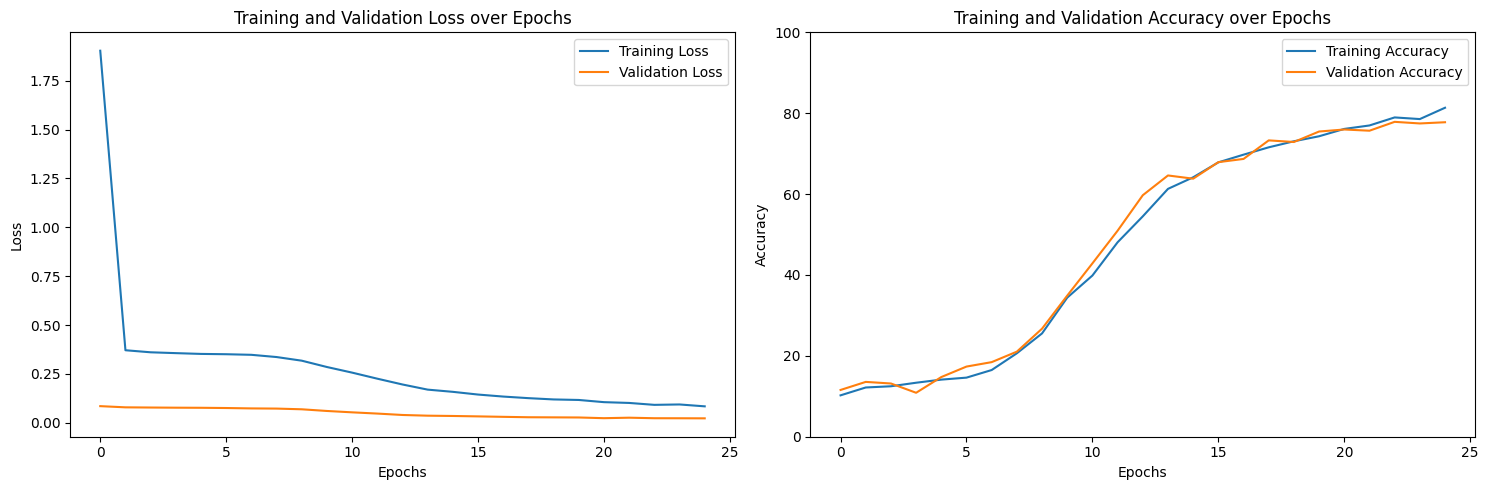

In [51]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()
